In [2]:
import sys
sys.path.insert(1, '../../scripts/')
from s3_support import *

import pandas as pd

# load data

## query

- org
- segment
- state
- trans count
- volume
- traffic

In [20]:
q = '''select
            t.org,
            o.segment,
            o.state,
            t.date,
            count(t.id) as trans_count,
            sum(t.amount) as trans_vol,
            sum(ga.views) as traffic
        from transactions as t
            left join organization as o on t.org=o.id
            left join ga on ga.org=t.org and ga.date=t.date
        where 
            t.year>=2023 and 
            (t.recurring=0 or t.recurring_origin=1)
        group by t.org, o.segment, t.date, o.state'''
df = redshift_query_read(q, schema='production')

In [21]:
df['conversion'] = df['trans_count'] / df['traffic']

In [22]:
df.tail(2)

,org,segment,state,date,trans_count,trans_vol,traffic,conversion
351650,450363,None,None,2023-09-28,1,26.0,NaN,NaN
351651,449446,None,None,2024-01-21,7,741.6,NaN,NaN


## review

### traffic

In [24]:
df['traffic'].describe()

count    7.254400e+04
mean     4.213870e+03
std      9.359492e+04
min      0.000000e+00
25%      1.000000e+01
50%      4.700000e+01
75%      3.000000e+02
max      1.133680e+07
Name: traffic, dtype: float64

### segment

In [63]:
df.groupby('segment')[['trans_count', 'trans_vol', 'conversion']].agg(['count', 'mean', 'median']).reset_index()

segment trans_count              \
                                                            count        mean   
0                  A - Arts; Culture; and Humanities        13039   14.143493   
1                       B - Educational Institutions        31174   78.557708   
2           C - Environmental Advocacy and Protection        8922   17.212508   
3                                         D - Animal        14518   44.590715   
4             E - Health; General and Rehabilitative        14059  151.160965   
5          F - Mental Health and Crisis Intervention         7531   24.608684   
6        G - Disease; Disorders; Medical Disciplines        11118  180.967890   
7                               H - Medical Research         3092   61.519405   
8                           I - Crime; Legal Related         3654   19.702518   
9                        J - Employment; Job Related          935    6.069519   
10                   K - Agriculture; Food; Nutrition        9802   37.424301   
11                              L - Housing; Shelter        14422   42.061434   
12                M - Public Safety; Disaster Relief         1626   22.123001   
13        N - Recreation; Sports; Leisure; Athletics         4465   41.293169   
14                             O - Youth Development        28923  135.201915   
15                                P - Human Services        44316   96.016382   
16  Q - International; Foreign Affairs; and Nation...        5660  501.900530   
17         R - Civil Rights; Social Action; Advocacy         2900   14.218276   
18      S - Community Improvement; Capacity Building         6018   30.144732   
19    T - Philanthropy; Voluntarism; and Grantmaking         7897  274.065974   
20     U - Science and Technology Research Institutes        1092   33.982601   
21            V - Social Science Research Institutes          810   23.459259   
22                       W - Public; Society Benefit         3086   56.797797   
23               X - Religion; Spiritual Development        37841  127.500092   
24        Y - Mutual/Membership Benefit Organizations        1102   50.183303   
25                                       Z - Unknown         1529    5.621321   
26  Z - Unknown ; T - Philanthropy; Voluntarism; a...          48    1.583333   

          trans_vol                         conversion                      
   median     count           mean   median      count      mean    median  
0     2.0     13039    1666.170734  210.000       1903  0.444642  0.304348  
1     3.0     31174   30632.274962  350.000       6636  0.405467  0.250000  
2     2.0      8922   12860.266599  150.000       1690       NaN  0.285714  
3     4.0     14518   19179.377901  300.000       3254       NaN  0.333333  
4     2.0     14059   49219.557286  306.000       2677       inf  0.200000  
5     2.0      7531    5600.423867  250.000       1305  0.419922  0.250000  
6     5.0     11118   21283.190010  433.920       2887  0.361583  0.176471  
7     4.0      3092   11658.511368  450.000        686  0.444669  0.250000  
8     3.0      3654    4225.297578  205.800        488  0.364541  0.214286  
9     1.0       935  109829.792011  415.000        147  0.424647  0.250000  
10    4.0      9802    4726.701486  484.755       2598  0.530550  0.479588  
11    3.0     14422    7761.855693  500.000       3313       NaN  0.333333  
12    2.0      1626    3559.814121  150.700        241  0.491883  0.375000  
13    2.0      4465    4704.984656  288.400        716  0.403275  0.230769  
14    3.0     28923   18159.806785  412.000       5738       NaN  0.236364  
15    3.0     44316   71596.271648  354.140       9247       NaN  0.333333  
16    3.0      5660   61747.284309  440.710       1059       NaN  0.333333  
17    3.0      2900    1009.342559  180.000        339  0.674418  0.750000  
18    2.0      6018    2004.621979  235.000       1033  0.470759  0.302326  
19    4.0      7897   20369.741547  450.000       1796  0.367916  0.194783  
20

### state

In [25]:
df['state'].value_counts()

FL               28359
CA               14788
Florida          13052
TX               12706
NY               10926
                 ...  
AK                  79
Puerto Rico         61
Nebraska            57
West Virginia       52
PR                   2
Name: state, Length: 107, dtype: int64

In [57]:
def noramlize_states(s):
    d = {'Florida': 'FL', 'West Virginia': 'WV', 'Puerto Rico': 'PR', 'Nebraska': 'NE',
         'California': 'CA', 'New York': 'NY', 'Pennsylvania': 'PA', 'Michigan': 'MI',
         'North Carolina': 'NC', 'Massachusetts': 'MA', 'Illinois': 'IL', 'Virginia': 'VA',
         'Washington': 'WA', 'Colorado': 'CO', 'Tennessee': 'TN', 'Arizona': 'AZ',
         'New Jersey': 'NJ', 'Indiana': 'IN', 'Minnesota': 'MN', 'Maryland': 'MD',
         'Wisconsin': 'WI', 'New Hampshire': 'NH', 'Oklahoma': 'OK', 'Missouri': 'MO',
         'District of Columbia': 'DC', 'Kentucky': 'KY', 'Texas': 'TX', 'Ohio': 'OH',
         'Connecticut': 'CT', 'Georgia': 'GA', 'New Mexico': 'NM', 'Kansas': 'KS',
         'Louisiana': 'LA', 'Rhode Island': 'RI', 'Utah': 'UT', 'Oregon': 'OR', 
         'South Carolina': 'SC', 'Vermont': 'VT', 'Iowa': 'IA', 'Maine': 'ME', 'Nevada': 'NV',
         'Alabama': 'AL', 'Hawaii': 'HI', 'Idaho': 'ID', 'South Dakota': 'SD', 'Alaska': 'AK',
         'Montana': 'MT', 'Arkansas': 'AR', 'Mississippi': 'MI', 'North Dakota': 'ND'}
    if s is not None and s.strip() in d:
        return d[s.strip()]
    return s

In [58]:
df['state'] = df['state'].apply(noramlize_states)

In [62]:
df.groupby('state')[['trans_count', 'trans_vol', 'conversion']].agg(['count', 'mean', 'median']).reset_index()

state trans_count                     trans_vol  \
                               count         mean median     count   
0                     AK         376    25.311170    2.0       376   
1                     AL        2485    19.973843    3.0      2485   
2                     AR        1131     8.142352    2.0      1131   
3                     AZ        6275    11.572271    2.0      6275   
4                Alberta         192     5.463542    2.0       192   
5       British Columbia         227    25.471366    5.0       227   
6                     CA       21449   292.230221    3.0     21449   
7                     CO        8321    41.997957    4.0      8321   
8                     CT        3773    15.702624    2.0      3773   
9                     DC        3428    58.635064    3.0      3428   
10                    DE         670  1254.792537    2.0       670   
11                    FL       41411    40.728719    3.0     41411   
12                    GA        4938    58.723370    3.0      4938   
13                    HI         897    44.586399    3.0       897   
14                    IA        2035    14.902211    2.0      2035   
15                    ID        1264    34.439873    2.0      1264   
16                    IL       11211   131.773704    3.0     11211   
17                    IN        6773    64.686254    3.0      6773   
18                    KS        2279    27.363317    4.0      2279   
19                    KY        4024    24.859095    3.0      4024   
20                    LA        2129    47.606388    4.0      2129   
21                    MA        9550   208.727958    4.0      9550   
22                    MD        5325    35.704225    3.0      5325   
23                    ME        1362     4.657122    2.0      1362   
24                    MI        9180    14.415577    2.0      9180   
25                    MN        5109    51.967313    3.0      5109   
26                    MO        5614    31.480406    3.0      5614   
27                    MS         590    41.850847    2.0       590   
28                    MT        1085     6.725346    2.0      1085   
29              Manitoba         401    95.521197    6.0       401   
30                    NC        9688   193.460879    3.0      9688   
31                    ND         903     3.507198    1.0       903   
32                    NE        1116   118.084229    2.0      1116   
33                    NH        2870    21.364460    3.0      2870   
34                    NJ        4990    28.585170    3.0      4990   
35                    NM        1985    22.151637    3.0      1985   
36                    NV        1822    67.538968    4.0      1822   
37                    NY       15531    48.065418    3.0     15531   
38                    OH        8883   144.253068    3.0      8883   
39                    OK        3055    40.191489    2.0      3055   
40                    OR        3515   650.972119    4.0      3515   
41               Ontario         772   121.538860    2.0       772   
42                    PA       11763   127.340984    3.0     11763   
43                    PR          63     3.968254    1.0        63   
44  Prince Edward Island         106     3.320755    2.0       106   
45                    RI         925    52.187027    5.0       925   
46                    SC        2728    31.401026    2.0      2728   
47                    SD        1006   114.836978    4.0      1006   
48                    TN        6863    24.283549    3.0      6863   
49                    TX       16443    84.918202    3.0     16443   
50                    UT         977    78.333675    2.0       977   
51                    VA        9444   220.849428    3.0      9444   
52                    VT        1651    23.231981    3.0      1651   
53                    WA        7111    26.689214    3.0      7111   
54                    WI        6328    64.933944    2.0      6328   
55                    WV     

# support functions

In [67]:
import numpy as np

import torch
import torch.nn as nn

import fastai
from fastai.tabular.all import *

In [106]:
conversion_median = df[df['traffic']>0]['conversion'].dropna().median()
print("filling NA conversion with median: {}".format(conversion_median))
print("training length: {:,} entries".format(len(df)))

filling NA conversion with median: 0.25
training length: 351,652 entries


In [120]:
df_nn = df.drop('org', axis=1).copy()
df_nn['segment'] = df_nn['segment'].astype('category')
df_nn['state'] = df_nn['state'].astype('category')
df_nn['conversion'] = df_nn['conversion'].replace(np.inf, np.nan).fillna(conversion_median)

In [121]:
df_nn['conversion'].describe()

count    351652.000000
mean          0.287686
std           0.182143
min           0.000386
25%           0.250000
50%           0.250000
75%           0.250000
max           3.000000
Name: conversion, dtype: float64

In [122]:
procs = [Categorify, FillMissing]

df_to_nn = TabularPandas(df_nn[['segment', 'state', 'conversion']],
                         procs, 
                         ['segment', 'state'], 
                         [], 
                         splits=RandomSplitter()(range_of(df_nn)),
                         y_names='conversion')

In [123]:
len(df_to_nn)

351652

In [124]:
dls = df_to_nn.dataloaders(1024)

In [125]:
len(dls.train), len(dls.valid)

(274, 69)

In [126]:
df_nn['conversion'].min(), df_nn['conversion'].max()

(0.00038575286100038574, 3.0)

In [127]:
learn = tabular_learner(dls, y_range=(0.0, 1.0), layers=[5, 5], n_out=1, loss_func=F.mse_loss)

SuggestedLRs(valley=0.0020892962347716093)

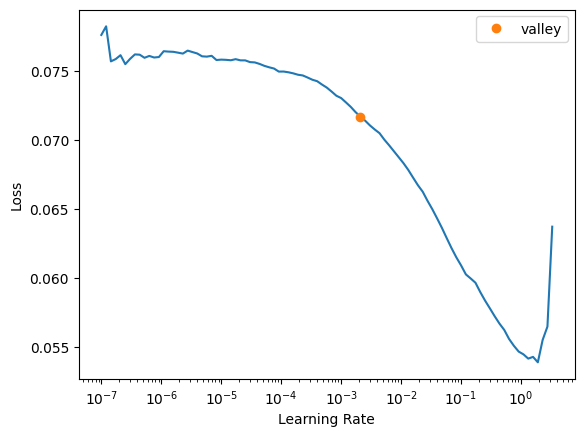

In [128]:
learn.lr_find()

In [129]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,time
0,0.049412,0.043902,00:03
1,0.033125,0.032202,00:03
2,0.032038,0.031960,00:03
3,0.032528,0.031894,00:03
4,0.032467,0.031865,00:03


# org